In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(345)
import numpy as np
np.random.seed(345)
from rich import print

## The tutorial starts here

### Running a negotiation

NegMAS has several built-in negotiation `Mechanisms`, negotiation agents (`Negotiators`), and `UtilityFunctions`. You can use these to run negotiations as follows.

Imagine a buyer and a seller negotiating over the price of a single object. First, we make an issue "price" with 50 discrete values. Note here, it is possible to create multiple issues, but we will not include that here. If you are interested, see the [NegMAS documentation](https://negmas.readthedocs.io/en/latest/tutorials/01.running_simple_negotiation.html) for a tutorial.

In [7]:
from negmas import (
    make_issue,
    SAOMechanism,
   TimeBasedConcedingNegotiator,
    SAONegotiator,
    ResponseType,
)
from negmas.preferences import LinearAdditiveUtilityFunction as UFun
from negmas.preferences.value_fun import IdentityFun, AffineFun
import matplotlib.pyplot as plt


# create negotiation agenda (issues)
issues = [
    make_issue(name="price", values=50),
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

The negotiation protocol in NegMAS is handled by a `Mechanism` object. Here we instantiate a`SAOMechanism` which implements the [Stacked Alternating Offers Protocol](https://ii.tudelft.nl/~catholijn/publications/sites/default/files/Aydogan2017_Chapter_AlternatingOffersProtocolsForM.pdf). In this protocol, negotiators exchange offers until an offer is accepted by all negotiators (in this case 2), a negotiators leaves the table ending the negotiation or a time-out condition is met. In the example above, we use a limit on the number of rounds of `20` (a step of a mechanism is an executed round).

Next, we define the utilities of the seller and the buyer. The utility function of the seller is defined by the ```
IdentityFun```  which means that the higher the price, the higher the utility function. The buyer's utility function is reversed. The last two lines make sure that utility is scaled between 0 and 1.

In [8]:
seller_utility = UFun(
    values=[IdentityFun()],
    outcome_space=session.outcome_space,
)

buyer_utility = UFun(
    values=[AffineFun(slope=-1)],
    outcome_space=session.outcome_space,
)

seller_utility = seller_utility.scale_max(1.0)
buyer_utility = buyer_utility.shift_by(50)
buyer_utility = buyer_utility.scale_max(1.0)

Then we add two agents with a conceding strategy. The negotiation ends with a status overview. For example, you can see if the negotiation timed-out, what agreement was found, and how long the negotiation took. Moreover, we output the full negotiation history. For a more visual representation, we can plot the session. This shows the bidding curve, but also the proximity to e.g. the Nash point.

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=18,
    time=0.047293299925513566,
    relative_time=0.9047619047619048,
    broken=False,
    timedout=False,
    agreement=(23,),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    threads={},
    last_thread='',
    current_offer=(23,),
    current_proposer='seller-91365038-f3d5-499a-9656-dadaef0afc22',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[('seller-91365038-f3d5-499a-9656-dadaef0afc22', (23,))],
    new_offerer_agents=[None],
    last_negotiator='seller'
)

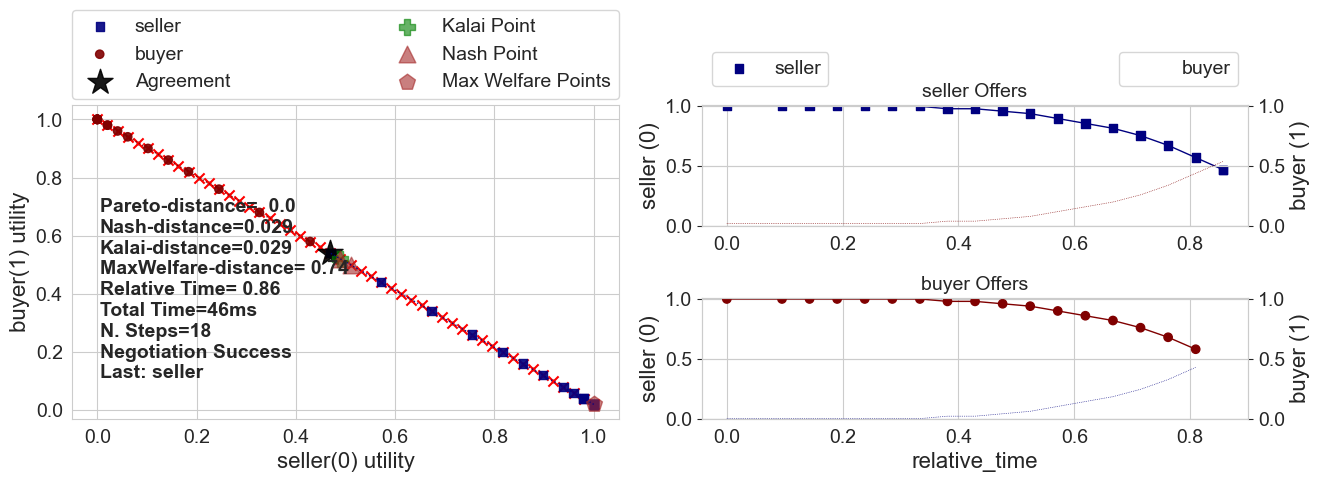

In [9]:

# create and add agent A and B
session.add(TimeBasedConcedingNegotiator(name="seller"), ufun=seller_utility)
session.add(TimeBasedConcedingNegotiator(name="buyer"), ufun=buyer_utility)

# run the negotiation and show the results
print(session.run())

session.plot(ylimits=(0.0, 1.01), show_reserved=False)
plt.show()



### Build Your First Negotiator

In this example, we will show a very simple RandomNegotiator. We develop a negotiator for the alternating offers protocol. We start by inheriting the base class ``SAONegotiator.
We only need to overwrite the ```propose``` method to build a randomly proposing agent. It receives the negotiation state which has all information available to the negotiator about the current state of the negotiation and generates an outcome to offer to the opponent. That is it. Moreover, we should know that the negotiator always have access to a NegotiatorMechanismInterface object that gives it unchanging information about the negotiation (for example the number of allowed rounds, any real-time limits on the negotiation, the number of partners, etc). This interface is accessible through the ```nmi```   member of the negotiator (NegotiatorMechanismInterface). With this knowledge, we can build our first negotiator which will simply offer randomly.


In [10]:
class RandomNegotiator(SAONegotiator):
    def propose(self, state):
        return self.nmi.random_outcomes(1)[0]

To slightly improve our negotiator, we adapt the acceptance strategy as well. The method we need to override here is the ```respond``` method.  The `ResponseType` returned is an enum with different possible options. We are only interested in three of them: ACCEPT_OFFER, REJECT_OFFER and END_NEGOTIATION.

In [11]:
class BetterRandomNegotiator(RandomNegotiator):
    def __init__(self, *args, acceptance_threshold=0.8, **kwargs):
        super().__init__(*args, **kwargs)
        self._th = acceptance_threshold

    def respond(self, state, source = ""):
	    offer = state.current_offer
	    if self.ufun(offer) > self._th:
	        return ResponseType.ACCEPT_OFFER
	    return ResponseType.REJECT_OFFER

We used a parameter ``acceptance_threshold`` to be able to adapt the threshold more easily, as can be seen in the ``init`` method.
